In [1]:
## The Baseline Method only use simple gait parameter feature, it only includes 2 dense layers
import scipy.io
import numpy as np
import random

## We delete people's data with low feedback score and remove people who kicked off the sensors during walking'
## So 20 people in total.
person_nums = [1,2,4,5,6,8,9,10,11,12,13,17,19,21,22,25,26,27,28,29]

from feature_emotion import feature_extract, split_data, label_unique_tuples
gts, sensor_nums, walk_nums, trace_nums, people_nums, spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features = feature_extract(person_nums)

walk_nums_all = np.squeeze(walk_nums)
trace_nums_all = np.squeeze(trace_nums)
people_nums_all = np.squeeze(people_nums)

## 0: train, 1: validation 2: test
flag_tr_val_te = split_data(walk_nums_all, trace_nums_all, people_nums_all)

In [2]:
## Data Normalization before training ans testing
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, LSTM
from sklearn.preprocessing import StandardScaler
scalers = []
X_train_normalized = []
X_val_normalized = []
X_test_normalized = []
train_idx = np.where(flag_tr_val_te ==0)[0]
np.random.shuffle(train_idx)
val_idx = np.where(flag_tr_val_te ==1)[0]
test_idx = np.where(flag_tr_val_te ==2)[0]

for i, feature in enumerate([spe_centr, delta_spe_centr, spe_crest, delta_spe_crest, spe_decrease, delta_spe_decrease, spe_entropy, delta_spe_entropy, spe_flatness, delta_spe_flatness, spe_flux, delta_spe_flux, spe_kurtosis, delta_spe_kurtosis, spe_skewness, delta_spe_skewness, spe_rfp, delta_spe_rfp, spe_slope, delta_spe_slope, spe_spread, delta_spe_spread, wlk_fre, wlk_fres_trace, cwt_figs_all, cwt_sum_all_0, cwt_sum_all_1, cwt_sum_all_2, cwt_sum_all_3, high_fre_compos, pitchs, low_fre_compos, auto_corrs, real_hils, imag_hils, dur_time_1_alls, dur_time_2_alls, jitters, shimmers, jitter_rap, hrs, feature, slope, zcrs, fft_features, energy_alls, log_energy_alls, smoothe_energy_alls, legendres, double_support_time, pdps_new, lpcs, ceps_features]):
    scaler = StandardScaler()
    if len(feature.shape)==2:
        X_train_i = feature[train_idx,:]
        X_val_i = feature[val_idx,:]
        X_test_i = feature[test_idx,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i)
        X_val_normalized_i = scaler.transform(X_val_i)
        X_test_normalized_i = scaler.transform(X_test_i)
        scalers.append(scaler)
    else:
        X_train_i = feature[train_idx,:,:]
        X_val_i = feature[val_idx,:,:]
        X_test_i = feature[test_idx,:,:]
        X_train_normalized_i = scaler.fit_transform(X_train_i.reshape(X_train_i.shape[0], -1)).reshape(X_train_i.shape)
        X_val_normalized_i = scaler.transform(X_val_i.reshape(X_val_i.shape[0], -1)).reshape(X_val_i.shape)
        X_test_normalized_i = scaler.transform(X_test_i.reshape(X_test_i.shape[0], -1)).reshape(X_test_i.shape)
        scalers.append(scaler)
    X_train_normalized.append(X_train_normalized_i)
    X_val_normalized.append(X_val_normalized_i)
    X_test_normalized.append(X_test_normalized_i)
y_train = gts[train_idx,:]
y_val = gts[val_idx,:]
y_test = gts[test_idx,:]

2023-12-14 00:57:20.654780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
X_train_normalized_new = []
combined_feature = np.empty((len(X_train_normalized[0]),0))
for feature in X_train_normalized:
    if len(feature.shape) == 3:
        X_train_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_train_normalized_new.append(feature)
X_train_normalized_new.append(combined_feature)

X_val_normalized_new = []
combined_feature = np.empty((len(X_val_normalized[0]),0))
for feature in X_val_normalized:
    if len(feature.shape) == 3:
        X_val_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_val_normalized_new.append(feature)
X_val_normalized_new.append(combined_feature)

X_test_normalized_new = []
combined_feature = np.empty((len(X_test_normalized[0]),0))
for feature in X_test_normalized:
    if len(feature.shape) == 3:
        X_test_normalized_new.append(feature)
    elif feature.shape[1] <20:
        combined_feature = np.hstack((combined_feature, feature))
    else:
        X_test_normalized_new.append(feature)
X_test_normalized_new.append(combined_feature)

In [4]:
## Build the baseline model for emotion recognition with dropout layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, concatenate, SimpleRNN, LSTM, Conv2D, Flatten, MaxPooling2D, GRU, AveragePooling2D, Dropout, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
def individual_model(features_list):
    input_layers = []
    hidden_layers = []
    combined_feature = np.empty((len(features_list[0]),0))
    for i, feature in enumerate(features_list):
        
        if len(feature.shape) == 3:
            input_i = Input(shape=(feature.shape[1], feature.shape[2]))
            input_layers.append(input_i)

            hidden_i = input_i[:,:,:,None]
            hidden_i = Conv2D(32, 3, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((3, 3))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Conv2D(16, 3, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((3, 3))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Conv2D(8, 1, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((2, 2))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Conv2D(4, 1, activation='relu')(hidden_i)
            hidden_i = AveragePooling2D((2, 2))(hidden_i)
            hidden_i = Dropout(0.5)(hidden_i)
            hidden_i = Flatten()(hidden_i)

            hidden_layers.append(hidden_i)
        elif feature.shape[1] <20:
            combined_feature = np.hstack((combined_feature, feature))
            
        else:  # For series features
            input_i = Input(shape=(feature.shape[1],))
            input_layers.append(input_i)
            hidden_i = Lambda(lambda x: x[:, :, None])(input_i)  # Add a new dimension
            hidden_i = LSTM(4)(hidden_i)
            hidden_layers.append(hidden_i)
    input_i = Input(shape=(combined_feature.shape[1],))
    input_layers.append(input_i)
    dense_num = np.max((1, int(combined_feature.shape[1]/2)))
    hidden_i = Dense(dense_num, activation='relu')(input_i)
    hidden_layers.append(hidden_i)
    print(combined_feature.shape)
    concat_layer = concatenate(hidden_layers)
    h = Dropout(0.2)(concat_layer)
    h = Dense(64, activation='relu')(h)
    h = Dense(32, activation='relu')(h)
    output_layer = Dense(2)(h)
    model = Model(inputs=input_layers, outputs=output_layer)
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import numpy as np

class PruningCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_pruning_factor=0.1, final_pruning_factor=0.5, start_epoch=0, end_epoch=None, frequency=1):
        super(PruningCallback, self).__init__()
        self.initial_pruning_factor = initial_pruning_factor
        self.final_pruning_factor = final_pruning_factor
        self.start_epoch = start_epoch
        self.end_epoch = end_epoch if end_epoch is not None else np.inf
        self.frequency = frequency
        self.pruned_weights = {}
        self.layer_importance = {}

    def get_pruning_factor(self, epoch):
        if epoch < self.start_epoch:
            return 0
        if epoch > self.end_epoch:
            return self.final_pruning_factor
        return self.initial_pruning_factor + (self.final_pruning_factor - self.initial_pruning_factor) * (epoch - self.start_epoch) / (self.end_epoch - self.start_epoch)

    def on_train_begin(self, logs=None):
        total_weight_magnitude = 0
        for layer in self.model.layers:
            if hasattr(layer, 'get_weights'):
                weights = layer.get_weights()
                layer_norm = sum(np.linalg.norm(w) for w in weights)
                total_weight_magnitude += layer_norm
                self.layer_importance[layer.name] = layer_norm
    
        # Normalize the layer importance values so they sum up to 1
        for layer_name in self.layer_importance:
            self.layer_importance[layer_name] /= total_weight_magnitude
    # def on_train_begin(self, logs=None):
    #     total_weight_magnitude = sum([np.linalg.norm(layer.get_weights()) for layer in self.model.layers if hasattr(layer, 'get_weights')])
    #     for layer in self.model.layers:
    #         if hasattr(layer, 'get_weights'):
    #             self.layer_importance[layer.name] = np.linalg.norm(layer.get_weights()) / total_weight_magnitude

    def get_layer_pruning_factor(self, layer_name, global_pruning_factor):
        if layer_name in self.layer_importance:
            importance = self.layer_importance[layer_name]
            adjusted_pruning_factor = global_pruning_factor * (1 - importance)
            return min(adjusted_pruning_factor, 1)  # Ensure the pruning factor is not greater than 1
        return global_pruning_factor
    def prune_weights(self, layer, global_pruning_factor):
        
        weights = layer.get_weights()
        layer_name = layer.name
        pruning_factor = self.get_layer_pruning_factor(layer_name, global_pruning_factor)

        if layer_name not in self.pruned_weights:
            self.pruned_weights[layer_name] = [np.zeros_like(w, dtype=bool) for w in weights]
        
        for i in range(len(weights)):
            weight = weights[i]
            # print(weight.shape)
            # print(weight.size)
            if weight.ndim > 1:  # Only prune dense or convolutional layers
                unpruned_weights = np.logical_not(self.pruned_weights[layer_name][i])
                num_unpruned = np.sum(unpruned_weights)
                num_pruning = min(num_unpruned, int(weight.size * pruning_factor) - np.sum(self.pruned_weights[layer_name][i]))
                num_pruning = int(weight.size * pruning_factor) - np.sum(self.pruned_weights[layer_name][i])
                if num_pruning > 0:
                    unpruned_flat_indices = np.flatnonzero(unpruned_weights)
                    abs_unpruned_weights = np.abs(weight[unpruned_weights])
                    pruning_flat_indices = np.argpartition(abs_unpruned_weights, num_pruning)[:num_pruning]
                    
                    indices = np.unravel_index(pruning_flat_indices, weight.shape)
                    self.pruned_weights[layer_name][i][indices] = True

                weights[i] = weights[i]*(~self.pruned_weights[layer_name][i])
                
        layer.set_weights(weights)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch - self.start_epoch) % self.frequency != 0:
            return

        pruning_factor = self.get_pruning_factor(epoch)
        for layer in self.model.layers:
            if isinstance(layer, (tf.keras.layers.Dense, tf.keras.layers.Conv2D)):
                self.prune_weights(layer, pruning_factor)
model = individual_model(X_train_normalized)
model.compile(loss='mean_absolute_error', optimizer='adam')
num_epochs = 100
rates = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
idx = 0
for r in rates:
# Gradually prune weights in dense and convolutional layers from 10% to 50% over the course of training, starting from epoch 0.
    model_name = './checkpoints/Adaptive_prune_model_'+str(idx)+'.h5'
    idx = idx+1
    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    pruning_callback = PruningCallback(initial_pruning_factor=0.01, final_pruning_factor=r, start_epoch=5, end_epoch=50, frequency=1)
    model.fit(X_train_normalized_new, y_train, epochs=num_epochs, batch_size=1024, validation_data=(X_val_normalized_new, y_val), callbacks=[pruning_callback, checkpoint])



In [7]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_0.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-11-04 12:54:10.519145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 12:54:10.530019: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 12:54:10.530261: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Test MAE:
1.3479246489997174
1.2727494816178258


In [8]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_1.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-04 12:54:41.290651: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_33_1/lstm_cell_70/recurrent_kernel/Assign' id:14889 op device:{requested: '', assigned: ''} def:{{{node lstm_33_1/lstm_cell_70/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_33_1/lstm_cell_70/recurrent_kernel, lstm_33_1/lstm_cell_70/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-04 12:54:42.485437: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_3_1/lstm_cell_40/bias/m/Assign' id:16254 op device:{requested: '', assigned: ''} def:{{{node lstm_3_1/lstm_cell_40/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_3_1/lstm_cell_40/bias/m, lstm_3_1/lstm_cell_40

Test MAE:
1.337201729175598
1.2494012788275686


In [9]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_2.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-04 12:55:22.931303: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_26_2/lstm_cell_100/bias/Assign' id:23009 op device:{requested: '', assigned: ''} def:{{{node lstm_26_2/lstm_cell_100/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_26_2/lstm_cell_100/bias, lstm_26_2/lstm_cell_100/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-04 12:55:24.614618: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_19_2/lstm_cell_93/kernel/v/Assign' id:26358 op device:{requested: '', assigned: ''} def:{{{node lstm_19_2/lstm_cell_93/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_19_2/lstm_cell_93/kernel/v, lstm_19_2/lstm_cell_93/kernel/v/Initializer/zeros)}}' w

Test MAE:
1.3451148485950823
1.2569576507247382


In [10]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_3.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-04 14:25:22.245620: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_32_3/lstm_cell_143/bias/Assign' id:33200 op device:{requested: '', assigned: ''} def:{{{node lstm_32_3/lstm_cell_143/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_32_3/lstm_cell_143/bias, lstm_32_3/lstm_cell_143/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-04 14:25:24.077562: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_18_3/lstm_cell_129/recurrent_kernel/m/Assign' id:34936 op device:{requested: '', assigned: ''} def:{{{node lstm_18_3/lstm_cell_129/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_18_3/lstm_cell_129/recurrent_kernel/m, lstm_18_3/lstm_cell_12

Test MAE:
1.3464249029248967
1.2393555100681712


In [11]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_4.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-04 15:23:43.576921: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_8_4/lstm_cell_156/recurrent_kernel/Assign' id:38580 op device:{requested: '', assigned: ''} def:{{{node lstm_8_4/lstm_cell_156/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_8_4/lstm_cell_156/recurrent_kernel, lstm_8_4/lstm_cell_156/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-04 15:23:45.818636: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_20_4/lstm_cell_168/bias/v/Assign' id:44845 op device:{requested: '', assigned: ''} def:{{{node lstm_20_4/lstm_cell_168/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_20_4/lstm_cell_168/bias/v, lstm_20_4/lstm_

Test MAE:
1.3448083063202552
1.2404483668240915


In [12]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_5.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-04 15:26:38.146277: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_32_5/lstm_cell_217/recurrent_kernel/Assign' id:51653 op device:{requested: '', assigned: ''} def:{{{node lstm_32_5/lstm_cell_217/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_32_5/lstm_cell_217/recurrent_kernel, lstm_32_5/lstm_cell_217/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-04 15:26:40.791405: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_11_5/lstm_cell_196/recurrent_kernel/v/Assign' id:53936 op device:{requested: '', assigned: ''} def:{{{node lstm_11_5/lstm_cell_196/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_11_5/lstm_cell

Test MAE:
1.3506845297761307
1.243161302515604


In [13]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_6.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-04 15:27:13.374062: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_21_6/lstm_cell_243/bias/Assign' id:59131 op device:{requested: '', assigned: ''} def:{{{node lstm_21_6/lstm_cell_243/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_21_6/lstm_cell_243/bias, lstm_21_6/lstm_cell_243/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-04 15:27:16.635256: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_6_6/lstm_cell_228/recurrent_kernel/v/Assign' id:63092 op device:{requested: '', assigned: ''} def:{{{node lstm_6_6/lstm_cell_228/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_6_6/lstm_cell_228/recurrent_kernel/v, lstm_6_6/lstm_cell_228/re

Test MAE:
1.3339769180472065
1.2328533678378875


In [14]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_7.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-04 15:27:47.992400: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_14_7/lstm_cell_273/recurrent_kernel/Assign' id:67233 op device:{requested: '', assigned: ''} def:{{{node lstm_14_7/lstm_cell_273/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_14_7/lstm_cell_273/recurrent_kernel, lstm_14_7/lstm_cell_273/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-04 15:27:51.389692: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_22_7/lstm_cell_281/recurrent_kernel/m/Assign' id:71920 op device:{requested: '', assigned: ''} def:{{{node lstm_22_7/lstm_cell_281/recurrent_kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_22_7/lstm_cell

Test MAE:
1.3371355109338947
1.2384727552484927


In [15]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_8.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-04 15:28:19.505637: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_16_8/lstm_cell_312/recurrent_kernel/Assign' id:76784 op device:{requested: '', assigned: ''} def:{{{node lstm_16_8/lstm_cell_312/recurrent_kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_16_8/lstm_cell_312/recurrent_kernel, lstm_16_8/lstm_cell_312/recurrent_kernel/Initializer/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-04 15:28:23.320340: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_30_8/lstm_cell_326/bias/m/Assign' id:81276 op device:{requested: '', assigned: ''} def:{{{node lstm_30_8/lstm_cell_326/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_30_8/lstm_cell_326/bias/m, lstm_30_8/l

Test MAE:
1.3442415178851443
1.239378116624641


In [16]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_9.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

2023-11-04 15:28:53.506477: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_12/kernel/Assign' id:83135 op device:{requested: '', assigned: ''} def:{{{node conv2d_12/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_12/kernel, conv2d_12/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-11-04 15:28:57.704479: W tensorflow/c/c_api.cc:304] Operation '{name:'lstm_7_9/lstm_cell_340/bias/v/Assign' id:90805 op device:{requested: '', assigned: ''} def:{{{node lstm_7_9/lstm_cell_340/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_7_9/lstm_cell_340/bias/v, lstm_7_9/lstm_cell_340/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run

Test MAE:
1.3370891480415625
1.246547739058251


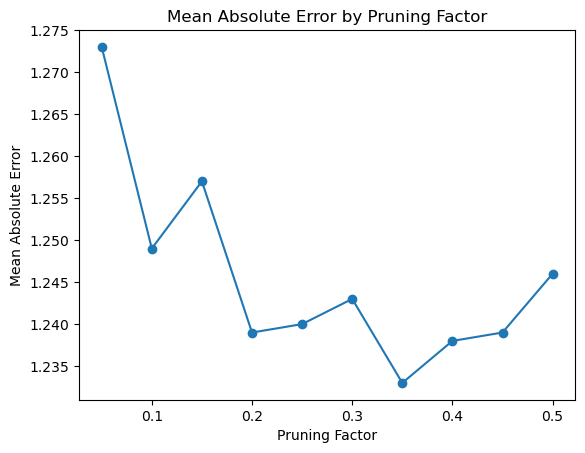

In [2]:
import matplotlib.pyplot as plt

# Data
pruning_factors = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
mean_absolute_errors = [1.273, 1.249, 1.257, 1.239, 1.240, 1.243, 1.233, 1.238, 1.239, 1.246]

# Plotting the data
plt.plot(pruning_factors, mean_absolute_errors, marker='o')  # 'o' creates circular markers for each data point

# Adding labels and title (if needed)
plt.xlabel('Pruning Factor')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error by Pruning Factor')
plt.savefig('prune_factor.svg', format='svg')  # Save as SVG
# Display the plot
plt.show()

In [4]:
## Evaluation on test data
import tensorflow as tf
model = tf.keras.models.load_model("./checkpoints/Adaptive_prune_model_6.h5")
from feature_emotion import feature_extract, split_data, label_unique_tuples
trace_wlk_num = label_unique_tuples(people_nums_all, walk_nums_all, trace_nums_all)
trace_wlk_num = np.array(trace_wlk_num )

y_pred = model.predict(X_test_normalized_new)
print('Test MAE:')
err = np.mean(np.abs(y_pred - y_test))
print(err)
## Evaluation: trace median vote
trace_num_test = trace_wlk_num[test_idx]
u = np.unique(trace_num_test)
pred_trace = np.empty((0, 2))
gt_trace = np.empty((0, 2))
for i in u:
  trace_idx = np.where(trace_num_test == i)[0]
  y_pred_trace = y_pred[trace_idx,:]
  pred = np.mean(y_pred_trace, axis = 0)
  pred_trace = np.vstack((pred_trace, pred))
  gt_t = y_test[trace_idx[0],:]
  gt_trace = np.vstack((gt_trace, gt_t))
print(np.mean(np.abs(pred_trace-gt_trace)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-12-14 00:57:57.228887: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 00:57:57.245238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-14 00:57:57.245547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Test MAE:
1.3339769180472065
1.2328533678378875


In [5]:
np.mean(np.abs(pred_trace-gt_trace),0)

array([1.23351384, 1.23219289])

In [6]:
np.mean(np.abs(y_pred - y_test),0)

array([1.30939322, 1.35856061])

In [8]:
np.abs(pred_trace-gt_trace).shape

(309, 2)

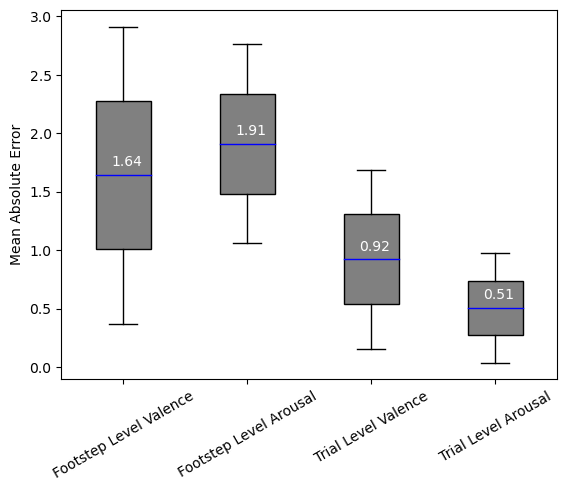

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os

directory = "figs"
# Sample data - two arrays with two columns each
array1 = np.abs(y_pred - y_test)  # Each sublist represents a column
array2 = np.abs(pred_trace-gt_trace)

# Separating the columns into individual arrays
data1, data2 = array1[0], array1[1]
data3, data4 = array2[0], array2[1]

# Combining all the individual arrays for plotting
data = [data1, data2, data3, data4]

# Creating the boxplot
box = plt.boxplot(data, patch_artist=True, 
                  boxprops=dict(facecolor='grey'),
                  medianprops=dict(color="blue"))

# Annotating the median values
for i, line in enumerate(box['medians']):
    x, y = line.get_xydata()[1] # Top of the median line
    plt.text(x-0.2, y + 0.05, f'{np.median(data[i]):.2f}', # Adjust y coordinate for text position
             horizontalalignment='center', 
             verticalalignment='bottom',   # Adjust vertical alignment
             fontsize=10, color='white')
# Adding titles and labels (optional)
# plt.title('Comparison of Absolute Error between Step Level and Trace Level')
plt.ylabel('Mean Absolute Error')
plt.xticks([1, 2, 3, 4], ['Footstep Level Valence', 'Footstep Level Arousal', 'Trial Level Valence', 'Trial Level Arousal'], rotation=30)
# Save the figure
file_path = os.path.join(directory, "trace_stp_v2.pdf")
plt.savefig(file_path, bbox_inches='tight')
# Displaying the plot
plt.show()


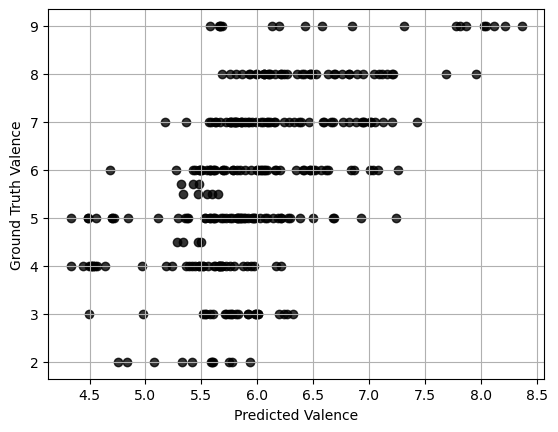

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure the directory exists
directory = "figs"
if not os.path.exists(directory):
    os.makedirs(directory)

# Assuming pred_trace and gt_trace are numpy arrays defined somewhere in your code:
# pred_trace = np.random.rand(100, 2)  # Example data
# gt_trace = np.random.rand(100, 2)    # Example data

# Your actual data should be loaded or defined here
# pred_trace = ...
# gt_trace = ...

# Scatter plot with alpha blending
plt.scatter(pred_trace[:, 0], gt_trace[:, 0], alpha=0.8, color='black')

# Set the title and labels
# plt.title('Scatter Plot of Predictions vs Ground Truth')
plt.xlabel('Predicted Valence')
plt.ylabel('Ground Truth Valence')
# Save the figure
file_path = os.path.join(directory, "scatter_valence.pdf")
plt.savefig(file_path, bbox_inches='tight')
# Show the plot with a grid
plt.grid(True)
plt.show()


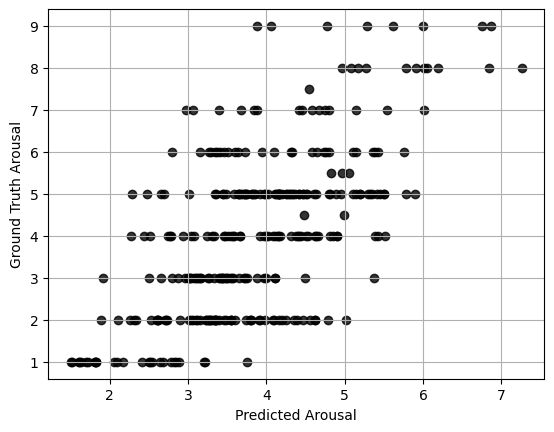

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming pred_trace and gt_trace are numpy arrays defined somewhere in your code:
# pred_trace = np.random.rand(100, 2)  # Example data
# gt_trace = np.random.rand(100, 2)    # Example data

# Your actual data should be loaded or defined here
# pred_trace = ...
# gt_trace = ...

# Scatter plot with alpha blending
plt.scatter(pred_trace[:, 1], gt_trace[:, 1], alpha=0.8, color='black')

# Set the title and labels
# plt.title('Scatter Plot of Predictions vs Ground Truth')
plt.xlabel('Predicted Arousal')
plt.ylabel('Ground Truth Arousal')
file_path = os.path.join(directory, "scatter_arousal.pdf")
plt.savefig(file_path, bbox_inches='tight')
# Show the plot with a grid
plt.grid(True)
plt.show()

In [13]:
from scipy.stats import pearsonr

# Assuming pred_trace and gt_trace are numpy arrays with your data
# pred_trace = np.random.rand(100, 2)  # Example data
# gt_trace = np.random.rand(100, 2)    # Example data

# Your actual data should be loaded or defined here
# pred_trace = ...
# gt_trace = ...

# Calculate the Pearson correlation coefficient
correlation, p_value = pearsonr(pred_trace[:, 0], gt_trace[:, 0])

print(f"Pearson correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")


Pearson correlation coefficient: 0.550
P-value: 0.000


In [15]:
correlation, p_value = pearsonr(pred_trace[:, 1], gt_trace[:, 1])
print(f"Pearson correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: 0.653
P-value: 0.000
